# Text classification using CNNs

`CNNs(Convolutional Neural Networs)` 구조를 이용하여 문장 분류를 해보도록 하겠습니다. 데이터는 `Pang & Lee (2004)`에서 사용한 subjectivity dataset을 이용하였습니다. (http://www.cs.cornell.edu/people/pabo/movie-review-data/)

이 노트북에 사용된 코드는 [이 곳](https://github.com/PacktPublishing/Deep-Learning-with-Keras/blob/master/Chapter05/finetune_word2vec_embeddings.py)에서 가지고 온 코드이며, 목적에 맞게 수정을 거쳤습니다.

## Data

**subjectivity** dataset은 5000개의 subjectivity 문장과 5000개의 objectivity 문장으로 구성되어 있습니다. subjectivity 문장들은 [Rotten Tomatoes](http://www.rottentomatoes.com)에 남겨진 영화 리뷰에서 가지고 온 문장들이며, objectivity 문장들은 [IMDB](http://www.imdb.com)에서 요약된 영화 줄거리에서 가지고 온 문장입니다. 실제 데이터를 수집한 저자들은 대부분의 경우 해당 레이블이 일치하였으나, 영화 줄거리 중 몇 개의 데이터가 실제로는 subjectivity일 수도 있다고 설명합니다. 

lab4-0 notebook을 이용하여 두 개의 텍스트 파일을 불러와서 **`data/subjectivity/massaged_subjectivity.txt`** 파일로 저장하였습니다. 해당 파일은 **label'\t'sentence**의 형태로 두 개의 텍스트 파일을 합쳐놓았습니다. 


## Convolutional Neural Networs for Sentence Classification

`CNN` 모델을 이용하여 텍스트를 분류하는 것은 `Yoon (2014)`(https://arxiv.org/abs/1408.5882) 에 잘 설명이 되어있습니다. 아래 그림을 통해 간략하게 구조를 살펴보겠습니다. 


![alt text](resources/cnn_structure.png "CNN structure in Yoon (2014)")

CNN은 인접한 계층의 연결성을 활용하여서 이미지의 공간 구조를 파악하였습니다. 문장 분류에서도 마찬가지입니다. 인접 계층의 연결성을 활용하여서 단어간의 공간 구조를 이용하여 문맥 정보를 유지하고, 그를 바탕으로 문장 분류를 하는 것입니다. 이번에는 `Yoon (2014)`의 구조와 유사하지만 훨씬 간단한 구조를 만들어서 살펴보도록 하겠습니다. 

기존의 **language model**에서는 `n-gram` 모델을 활용하여 단어의 문맥 구조를 파악하였습니다. 지금 사용할 CNN에서도 이와 유사한 과정이 있습니다. 한 번에 전체를 보는 것이 아니라 적절한 `필터 크기/커널 크기(filter/kernel size)`를 부여하여서 해당 범위 안의 단어를 살펴보는 `convolution filter`를 학습하게 되고, `max-pooling`을 통해서 문장에서 가장 중요한 특징(feature)을 나타내는 벡터를 얻게 됩니다. 

이미지의 경우 크기가 동일한 데이터를 많이 구할 수 있지만, 텍스트 데이터의 경우 문장의 길이를 특정짓기가 매우 어렵습니다. 그렇기 때문에 대부분의 경우 가장 긴 문장의 길이만큼의 배열로 설정한 이후, 문장의 길이가 짧을 경우 남은 공간을 `zero padding`을 하거나 `unknown word`로 처리하게 됩니다. 

이전에 `word embedding`에서와 마찬가지로 단어들은 각각의 index로 변환되어야 합니다. index로 변환된 단어들은 해당 단어의 벡터값으로 변환된 후, 입력값으로 사용됩니다. 입력값은 `Convolution layer`로 연결된 이후, `filter/kernel size`에 해당하는 단어들의 값을 미리 설정한 `conv_dim`만큼의 다른 방법으로 연산합니다. 각각의 `conv_dim`의 값들은 `max-pooling`의 과정을 통해 각각 하나의 값을 산출하고, `Fully connected layer`의 구조로 `구분할 클래스의 갯수`만큼의 노드로 출력하게 됩니다. `softmax` 활성화를 하게 되면 출력값은 확률로 변화되는데, 하나는 **subjectivity**, 다른 하나는 **objectivity**에 해당하는 값입니다. 

## Import modules

필요한 모듈을 불러오고, 재실행을 대비하여 랜덤 시드를 설정하겠습니다. 

In [3]:
from gensim.models import KeyedVectors

from keras.layers.core import Dense, Dropout, SpatialDropout1D
from keras.layers.convolutional import Conv1D
from keras.layers.embeddings import Embedding
from keras.layers.pooling import GlobalMaxPooling1D

from keras.models import Sequential

from keras.preprocessing.sequence import pad_sequences

from keras.utils import np_utils

from sklearn.model_selection import train_test_split

import collections
import matplotlib.pyplot as plt
import nltk
import numpy as np
import codecs

%matplotlib inline

np.random.seed(42)

Using TensorFlow backend.


nltk를 불러온 이후, word_tokenizer를 실행하기 위해서는 `punkt` 패키지가 필요합니다. 아래 셀을 실행하여서 다운받겠습니다. 

In [2]:
%%bash
python3 -m nltk.downloader -d /usr/local/share/nltk_data -u https://pastebin.com/raw/D3TBY4Mj punkt

[nltk_data] Downloading package punkt to /usr/local/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Hyperparameters

필요한 파라미터들을 설정하도록 하겠습니다. 

In [19]:
data_file = "data/subjectivity/massaged_subjectivity.txt"
model = "data/GoogleNews-vectors-negative300.bin"
embed_dim = 300  # word2vec 모델에서 설정된 embedding 차원의 값입니다.
hidden_dim = 256 # Filter를 몇 개의 방법으로 연산할지 정합니다
filter_size = 3  # Filter/kernel size 값입니다
batch_size = 64  # 한 번에 몇 개의 데이터를 처리할 지 정합니다
num_epoch = 10   # 전체 데이터를 몇 번 반복해서 학습할지 정합니다.

## Other parameters

위에서 설정한 파라미터 이외에도 다음의 정보가 필요합니다. 해당 값들은 임의로 설정할 수 없고, 데이터를 분석하여 산출하여야 합니다. 
 1. 사용된 단어의 수
 2. 단어-인덱스 관계를 정의한 `<dict>`
 3. 인덱스-단어 관계를 정의한 `<dict>`
 
먼저 단어의 갯수를 세어보도록 하겠습니다. 

In [17]:
## Count the number of words
counter = collections.Counter()
f = open(data_file, "rb")
seq_len = 0
for line in f:
    line = line.decode("ascii", "ignore")
    _, sent = line.strip().split("\t")
    words = [x.lower() for x in nltk.word_tokenize(sent)]
    if len(words) > seq_len:
        seq_len = len(words)
    for word in words:
        counter[word] += 1
f.close()

print(len(list(counter.keys())))
print(seq_len)

22601
122


사용할 데이터에는 총 22,601개의 단어가 있다는 것을 볼 수 있습니다. 그리고 가장 긴 문장은 122개의 단어가 사용되었습니다. 

다음으로 `단어-인덱스` 관계를 정의하는 `<dict>`를 생성하겠습니다. 

In [15]:
word2idx = collections.defaultdict(int)
for wid, word in enumerate(counter):
    # print(wid, word)
    word2idx[word] = wid + 1
num_words = len(word2idx) + 1
print(num_words)

22602


마지막에 하나를 더해주는 것은 지금 다루는 데이터에서는 괜찮지만 나중에 혹시나 사전에 등록되어있지 않은 단어를 예상해야할 경우를 대비하는 것입니다. 

다음으로 간단하게 `인덱스-단어` 관계를 정의하는 `<dict>`를 생성하겠습니다. 

In [16]:
idx2word = {v:k for k, v in word2idx.items()}
print(len(idx2word) + 1)

22602


## Data preparation

다음으로 사용할 데이터를 준비해보도록 하겠습니다. 

문장의 단어들은 각각 `word2idx`를 이용하여 인덱스로 변환될 것이며, 각 문장의 **subjectivity**를 뜻하는 `label`은 **np_utils**를 이용하여 `one-hot encoding`으로 변경할 것입니다. 

문장의 길이가 가장 긴 문장의 길이(122)보다 짧을 경우, 빈 공간을 `padding` 처리 하도록 하겠습니다. 

In [23]:
X, y = [], []
f = open(data_file, "rb")
for line in f:
    line = line.decode("ascii", "ignore")
    label, sent = line.strip().split("\t")
    y.append(int(label))
    words = [x.lower() for x in nltk.word_tokenize(sent)]
    wids = [word2index[word] for word in words]
    X.append(wids)
f.close()
X = pad_sequences(X, maxlen=seq_len)
y = np_utils.to_categorical(y)

`sklearn` 모듈에는 training/test 데이터를 분리해주는 함수가 포함되어 있습니다. 해당 함수를 사용하여서 데이터를 무작위로 섞은 이후, 학습용 데이터와 테스트용 데이터로 구분하도록 하겠습니다. 

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7000, 122) (3000, 122) (7000, 2) (3000, 2)


총 10,000개의 데이터 중 **7,000개**는 학습용, **3,000**개는 테스트용으로 분리된 것을 확인할 수 있습니다. 문장의 경우 `padding`을 통해 길이를 *122*개로 통일하였으며, label의 경우 `subjectivity/objectivity`의 *2*개로 표현된 것을 확인할 수 있습니다. 

## word2vec & embedding layer

이전에 살펴보았던 `Google word2vec` 모델을 이용하여 이번 notebook을 진행할 것입니다. 해당 모델을 **word2vec**이라는 변수 이름으로 불러왔습니다. 

**embedding layer**는 단어의 인덱스를 이용하여 각각의 단어를 **300개**의 *word embedding*으로 변경해주는 역할을 합니다. word embedding은 모델이 학습되는 과정에서 조금씩 변화하게 됩니다. embedding_layer를 만드는 방법은 일단 **전체 단어 크기 x word embedding 크기**의 zero-array를 만든 이후, 각 단어의 인덱스에 해당하는 행을 word embedding 값으로 변화시키는 것입니다. 

In [26]:
# load word2vec model
word2vec = KeyedVectors.load_word2vec_format(model, binary=True)
embedding_layer = np.zeros((num_words, embed_dim))
for word, idx in word2idx.items():
    try:
        embedding_layer[idx, :] = word2vec[word]
    except KeyError:
        pass

## Build a model

실제 학습을 할 모델의 구조를 만들어 보겠습니다. 먼저 데이터를 입력받은 이후(word index) 이를 word embedding 값으로 변환해줍니다. 이후 오버피팅을 방지하기 위하여 dropout 레이어를 추가해준 이후, `합성곱 레이어 (Convolutional layer)`를 생성합니다. `max pooling`을 통해 문장에서 가장 중요한 값을 `hidden_dim` 갯수만큼 추출한 이후, `fully connected layer (Dense layer)`의 형식으로 `one-hot encoding` 형태의 output으로 출력합니다. 

In [28]:
model = Sequential()

model.add(Embedding(num_words, embed_dim, input_length=seq_len,
                    weights=[embedding_layer],
                    trainable=True))

# output => batch size * seq_len * embed_dim

model.add(SpatialDropout1D(0.2))

model.add(Conv1D(filters=hidden_dim, kernel_size=filter_size, activation="relu"))

# output => hidden_dim number of layers, with filter_size kernel. 

model.add(GlobalMaxPooling1D())

model.add(Dense(2, activation="softmax"))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 122, 300)          6780600   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 122, 300)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 120, 256)          230656    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 7,011,770
Trainable params: 7,011,770
Non-trainable params: 0
_________________________________________________________________


## Training the model

이제는 모델을 실제로 학습시켜보겠습니다. 이전과 다르게 `model.fit`의 결과를 다른 변수에 할당하는 것은 이후에 실제 그래프로 학습 과정을 확인하기 위해서입니다. 

In [29]:
history = model.fit(X_train, y_train, batch_size = batch_size, epochs = num_epoch, validation_data = (X_test, y_test)) 

Train on 7000 samples, validate on 3000 samples
Epoch 1/10
7000/7000 [==============================] - 46s 7ms/step - loss: 0.3032 - acc: 0.8823 - val_loss: 0.2004 - val_acc: 0.9197
Epoch 2/10
7000/7000 [==============================] - 48s 7ms/step - loss: 0.1149 - acc: 0.9616 - val_loss: 0.1902 - val_acc: 0.9283
Epoch 3/10
7000/7000 [==============================] - 50s 7ms/step - loss: 0.0425 - acc: 0.9903 - val_loss: 0.1913 - val_acc: 0.9303
Epoch 4/10
7000/7000 [==============================] - 50s 7ms/step - loss: 0.0155 - acc: 0.9981 - val_loss: 0.2071 - val_acc: 0.9307
Epoch 5/10
7000/7000 [==============================] - 48s 7ms/step - loss: 0.0069 - acc: 0.9997 - val_loss: 0.2180 - val_acc: 0.9310
Epoch 6/10
7000/7000 [==============================] - 46s 7ms/step - loss: 0.0034 - acc: 0.9999 - val_loss: 0.2348 - val_acc: 0.9257
Epoch 7/10
7000/7000 [==============================] - 46s 7ms/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.2420 - val_acc: 0.9307
Epoch 8

학습 결과로 `training data`에 대해서는 100% 정확도를 보였으며, `test data`에 대해서는 대략 **93%**의 정확도를 보였음을 알 수 있습니다. 

## Look into the training process

`python`은 `matplotlib` 이라는 모듈을 통해 데이터를 이용, 그래프를 그릴 수 있는 기능을 제공합니다. 앞서 `history` 변수에 저장된 내용을 토대로 실제 학습 과정에서 `loss` 및 `accuracy`가 어떻게 변화하였는지 확인해볼 수 있습니다. 

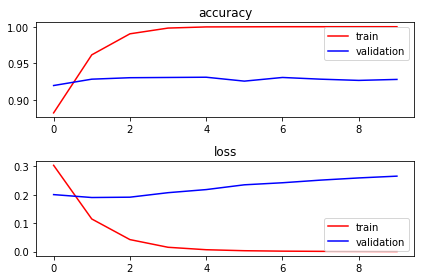

In [32]:
# plot accuracy
plt.subplot(211)
plt.title("accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

# plot loss function
plt.subplot(212)
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

그래프를 보았을 때, `오버피팅(over-fitting)`이 발생한 것을 볼 수 있습니다. `hyperparameter` 수정이나 `regularization` 등의 방법을 통해서 오버피팅을 더욱 효과적으로 방지할 수 있을 것이라고 생각되며, filter_size의 경우에도 `Yoon (2014)` 논문에서는 하나의 filter_size를 사용한 것이 아니라 세 가지 다른 filter_size를 사용한 결과를 합쳐서 결과를 내는 방법을 선택했습니다. 지금은 이정도로 마무리짓고 넘어가겠습니다. 관심있으신 분들은 [Yoon (2014)](https://arxiv.org/abs/1408.5882) 논문을 참고하시고 실제로 구현해보셔도 좋을 것 같습니다. 

## Evaluation

마지막으로 모델의 결과를 살펴보도록 하겠습니다. 

In [34]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test score: {:.3f}, accuracy: {:.3f}".format(score[0], score[1]))

3000/3000 [==============================] - 3s 1ms/step
Test score: 0.265, accuracy: 0.928
